# Progressive metal band classification
### This project is about classifying 5 bands using machine learning algorithms.

## Step 1 : Import the necessary modules

In [1]:
import pandas as pd
import os
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
from pyaudio_features import *
from plots import plot_wav
from pyaudio_features import *
from feature_selection import *
from models import *
from sklearn.metrics import confusion_matrix

warnings.simplefilter('ignore')

## Step 2 : Data Importing
### The raw data is comprised of the riffs that were created manually. For each band a total of 50 songs were extracted as URLs from youtube. From the URLs, wavs were obtained. Each wav (song) was then imported into a trimming software. In this software, 10+ seconds riffs were extracted from the wavs in parts were there was heavy riffs without voice. 
### We use data_import function from pyaudio_features.py to get the path of each wav file and also the labels that consists of the 5 bands

In [2]:
# Import the wav files and extract the classification labels
wavs, labels = data_import('..\\raw_data')
# Path files
print('---Path to Wav files for each band---')
print()
wavs[5:250:25]

---Path to Wav files for each band---



['..\\raw_data\\Dream_Theater\\A dramatic turn of events\\Outcry_riff.wav',
 '..\\raw_data\\Dream_Theater\\Metropolis_Part_2\\Strange Déjà Vu_riff.wav',
 '..\\raw_data\\Gojira\\Fortitude\\Gojira - New Found_riff.wav',
 '..\\raw_data\\Gojira\\Terra_incognita\\Clone_riff.wav',
 '..\\raw_data\\Mastodon\\Blood Mountain\\Siberian Divide_riff.wav',
 '..\\raw_data\\Mastodon\\Leviathan\\MASTODON - ＂Iron Tusk＂ (Official HD Music Video)_riff.wav',
 '..\\raw_data\\Opeth\\Blackwater_Park\\Opeth - The Leper Affinity_riff.wav',
 '..\\raw_data\\Opeth\\Orchid\\Forest Of October_riff_final.wav',
 '..\\raw_data\\Symphony X\\Odyssey\\Wicked_riff.wav',
 '..\\raw_data\\Symphony X\\The_Divine_Wings_Of_Tragedy\\The_Eyes_of_Medusa_riff.wav']

### Visualizing the information of the path to wav files

In [3]:
print('Path format = ', wavs[5],'\n')

file_path_example = wavs[5]
path_components = file_path_example.split(os.sep)

# Extract the relevant information
band = path_components[-3]
album = path_components[-2]
song = path_components[-1].replace('_riff.wav','')

print("Band name:", band, '\n')
print("Album:", album, '\n')
print("Song:", song, '\n')

Path format =  ..\raw_data\Dream_Theater\A dramatic turn of events\Outcry_riff.wav 

Band name: Dream_Theater 

Album: A dramatic turn of events 

Song: Outcry 



In [5]:
# See classification labels
set(labels)

{'Dream_Theater', 'Gojira', 'Mastodon', 'Opeth', 'Symphony X'}

### Each class is balanced, containing 50 riffs

In [5]:
print(f"Total Data is {len(wavs)} riffs \n")
print(f"Total Dream_Theater riffs = {labels.count('Dream_Theater')} \n")
print(f"Total Gojira riffs = {labels.count('Gojira')} \n") 
print(f"Total Mastodon riffs = {labels.count('Mastodon')} \n")
print(f"Total Opeth riffs = {labels.count('Opeth')} \n")
print(f"Total Symphony_X riffs = {labels.count('Symphony X')} \n")

Total Data is 250 riffs 

Total Dream_Theater riffs = 50 

Total Gojira riffs = 50 

Total Mastodon riffs = 50 

Total Opeth riffs = 50 

Total Symphony_X riffs = 50 



## Step 3: Trim riffs to 10 seconds each
### The wavs that were exported from the software were mostly 10+ seconds. We want to have the same time for each riff, so all instances can be equally represented.
### Goal is to set all audio length to 10 seconds.

In [6]:
for wav in wavs[:10]:
    y, _ = librosa.load(wav)
    duration = librosa.get_duration(y=y, sr = 22050)
    print(f"Audio duration = {duration:.3f} seconds")

Audio duration = 12.658 seconds
Audio duration = 12.400 seconds
Audio duration = 18.635 seconds
Audio duration = 14.851 seconds
Audio duration = 14.021 seconds
Audio duration = 11.601 seconds
Audio duration = 13.204 seconds
Audio duration = 11.141 seconds
Audio duration = 13.396 seconds
Audio duration = 13.870 seconds


### There are very few instances with riffs less than 10 seconds and we leave them as they are
### Using trim_wav function from pyaudio_features.py to set each instance wav to a maximum of 10 seconds.

In [7]:
y = trim_wav(wavs)
for aud in y[:1000]:
    duration = librosa.get_duration(y=aud, sr = 22050)
    print(f"Audio duration = {duration:.3f} seconds")

Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio duration = 10.000 seconds
Audio du

### Checking some waveforms for the different classes of the dataset
### Using plot_wav function from plots.py

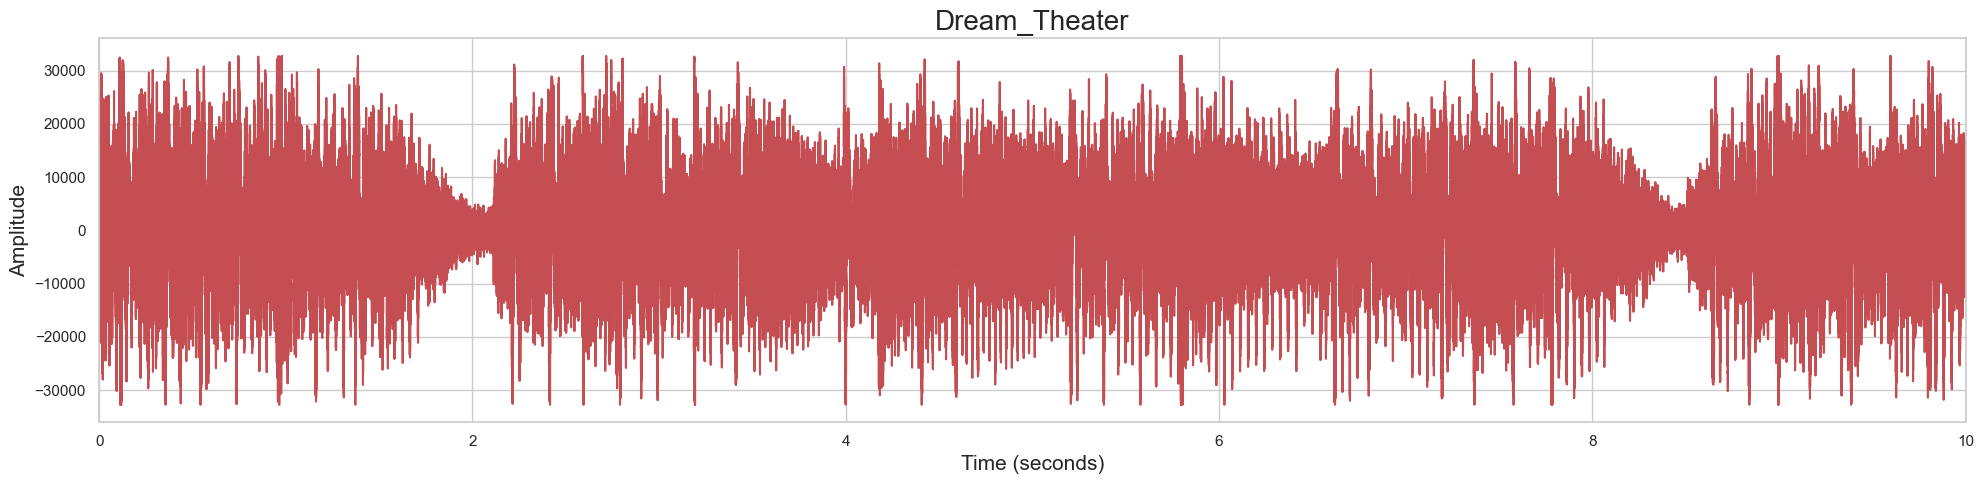

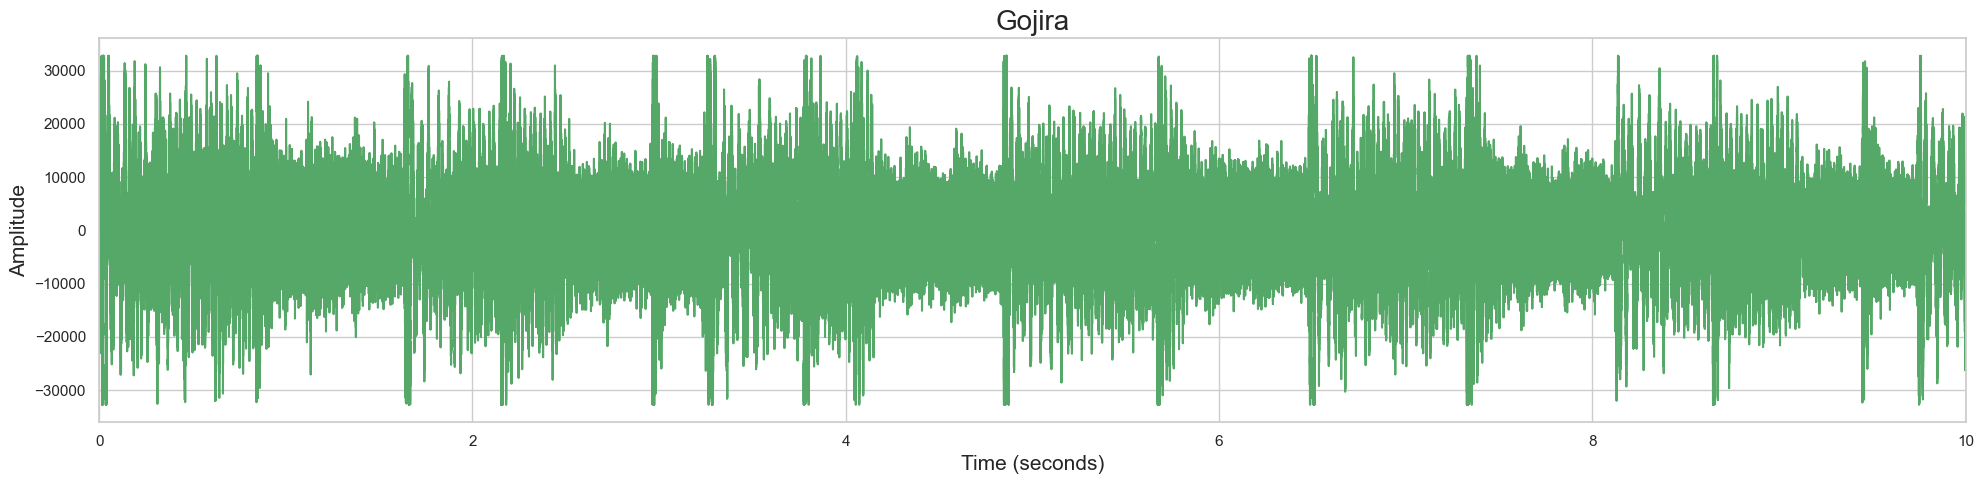

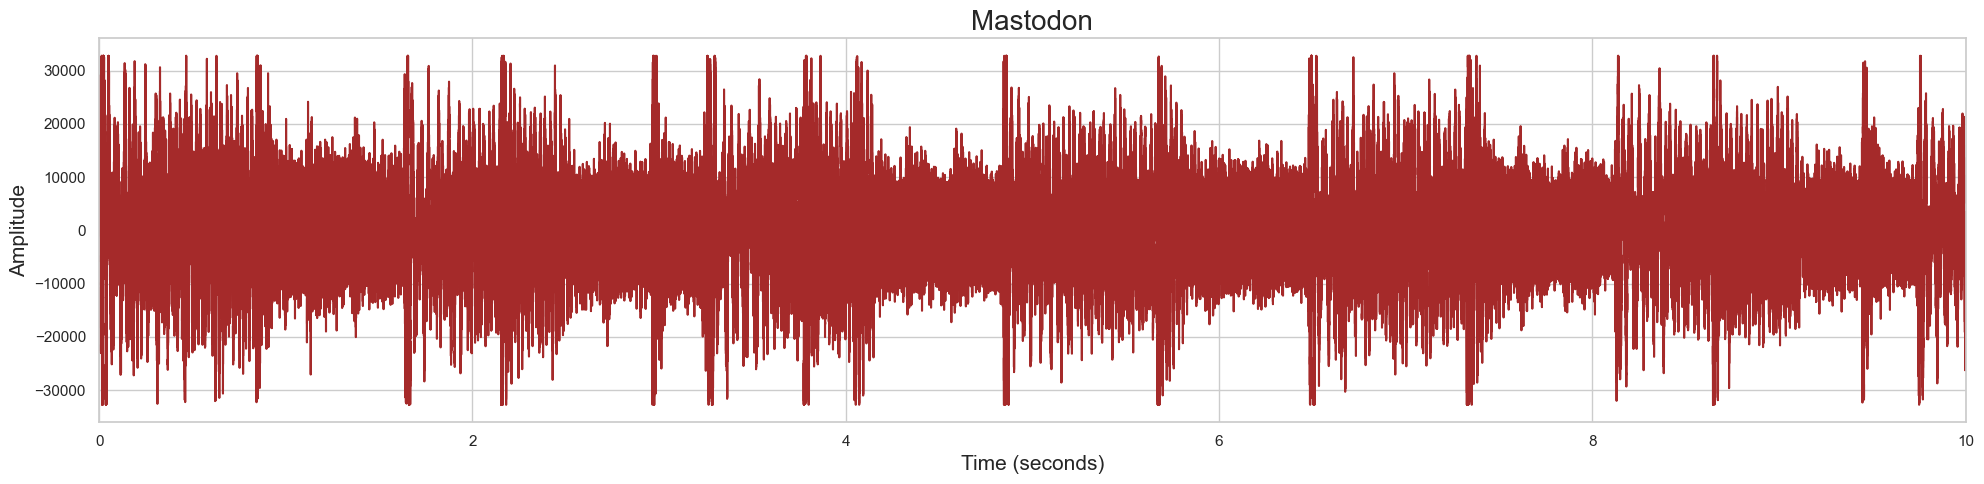

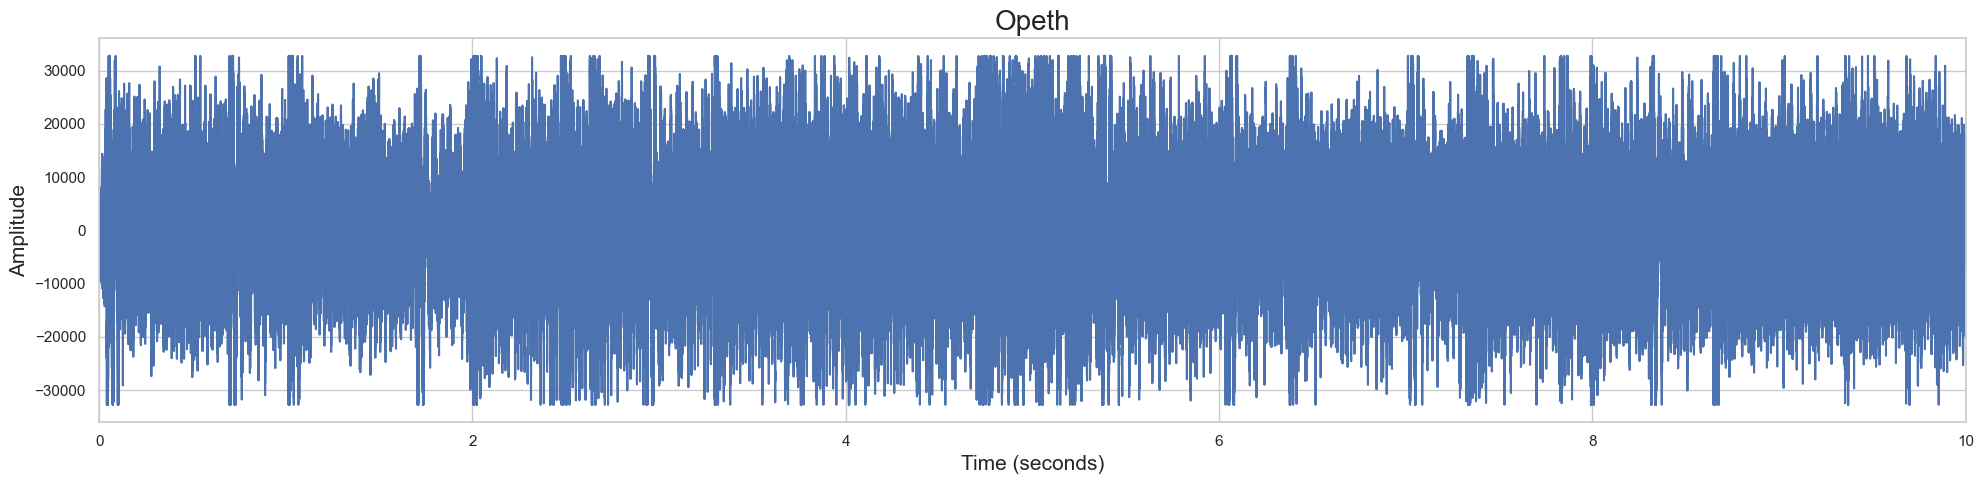

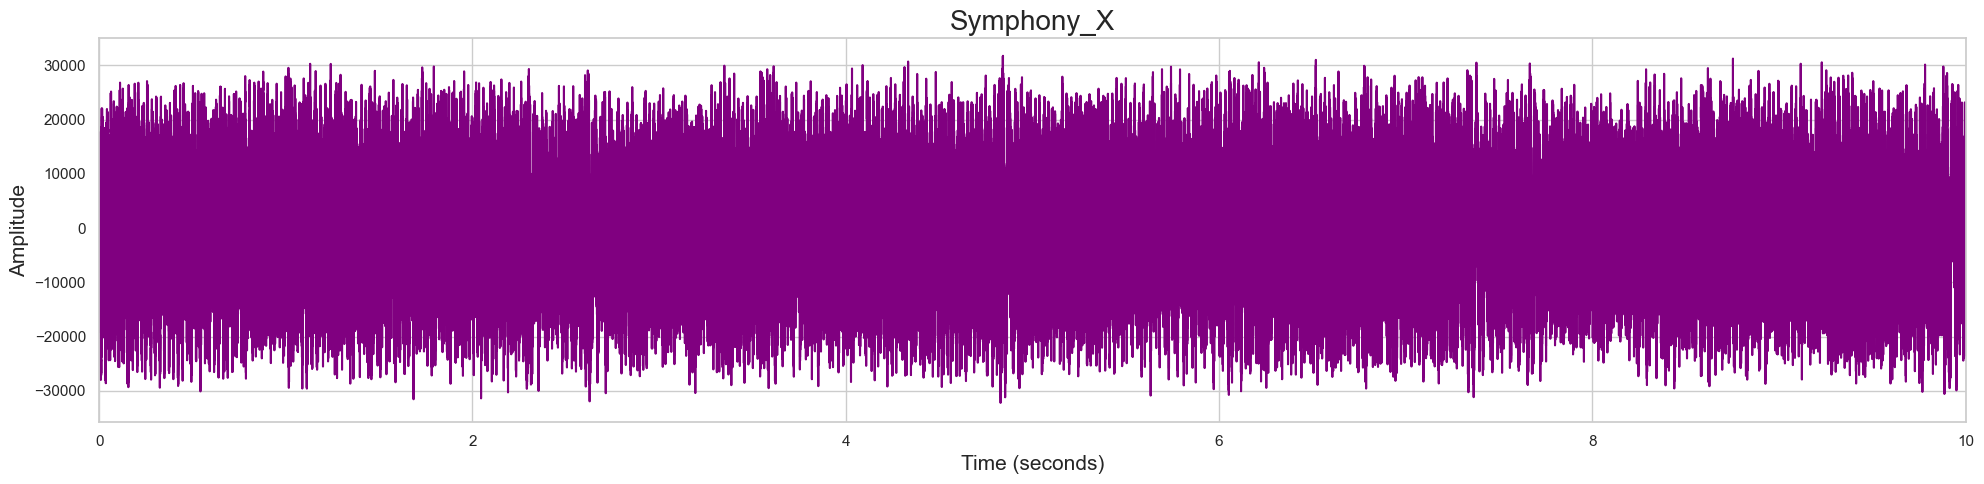

In [8]:
band_0 = wavs[0]
band_1 = wavs[52]
band_2 = wavs[101]
band_3 = wavs[151]
band_4 = wavs[201]

plot_wav(band_0,'Dream_Theater',color='r')
plot_wav(band_1,'Gojira',color='g')
plot_wav(band_1,'Mastodon',color='brown')
plot_wav(band_2,'Opeth',color='b')
plot_wav(band_3,'Symphony_X',color='purple')

## Step 4: Feature Extraction
### Using pyaudioanalysis to exctract short-term features. The short term window frame size is 60ms with 30ms step (50% overlap). After all the short term window features were created for each instance, the feature vector was obtained. The feature vector consists of those features mean and standard deviation. The features that are computed are zero crossing rate, spectral features, mfccs, chroma, delta etc.. 
### Size of the feature vector is 136
### pyaudio_featurize function is used that leverage PyAudioAnalysis for feature extraction 
### PyAudioAnalysis https://github.com/tyiannak/pyAudioAnalysis


In [9]:
dataframe = pyaudio_featurize(y)

In [10]:
print("Dataframe")
dataframe.head()

Dataframe


,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0.105385,0.055962,2.973362,0.217836,0.238056,0.748002,0.003121,0.127363,-22.209769,1.913764,...,0.051043,0.007912,0.026150,0.008822,0.035321,0.003834,0.011905,0.030127,0.007358,0.010504
1,0.099801,0.051757,2.926394,0.219995,0.244148,0.658857,0.003192,0.105030,-22.290414,2.044807,...,0.046716,0.009136,0.027987,0.006359,0.052643,0.004406,0.013627,0.028635,0.003277,0.011269
2,0.122400,0.040627,3.079595,0.231968,0.235578,0.986766,0.002018,0.193992,-22.058860,1.761161,...,0.034062,0.006829,0.017773,0.007676,0.045061,0.005693,0.008787,0.021582,0.003156,0.009797
3,0.097231,0.055454,2.932941,0.218980,0.242909,0.622092,0.004002,0.118814,-23.565676,2.060746,...,0.035857,0.004294,0.017782,0.003647,0.041944,0.002085,0.014815,0.041633,0.001823,0.010720
4,0.101097,0.056286,3.006323,0.217306,0.232390,0.758749,0.002953,0.135059,-22.215426,1.872764,...,0.044225,0.004906,0.025444,0.004947,0.051583,0.007434,0.030660,0.023579,0.002763,0.011933


In [11]:
pd.set_option('display.max_columns', None)
print(f'Total features of the dataset = {len(dataframe.columns)} \n')
print(dataframe.columns)

Total features of the dataset = 136 

Index(['zcr_mean', 'energy_mean', 'energy_entropy_mean',
       'spectral_centroid_mean', 'spectral_spread_mean',
       'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean',
       'mfcc_1_mean', 'mfcc_2_mean',
       ...
       'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std',
       'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std',
       'delta chroma_10_std', 'delta chroma_11_std', 'delta chroma_12_std',
       'delta chroma_std_std'],
      dtype='object', length=136)


## Step 5: Insert the labels into the dataframe
### Label encoding is necessary to convert strings to integers for the classification procedure. The labels are automatically assigned as Dream_Theater = 0, Opeth = 1, Gojira = 2, Symphony_X = 3, Mastodon = 4.

In [12]:
merge_labels(dataframe,labels)
dataframe['Band']

0      0
1      0
2      0
3      0
4      0
      ..
245    4
246    4
247    4
248    4
249    4
Name: Band, Length: 250, dtype: int64

In [13]:
dataframe.to_csv('../clean_data/cleaned_dataset',index=False)

## Step 6: Feature selection
### We use pearson corellation between each feature and create heatmap to inspect if some features have high corellation

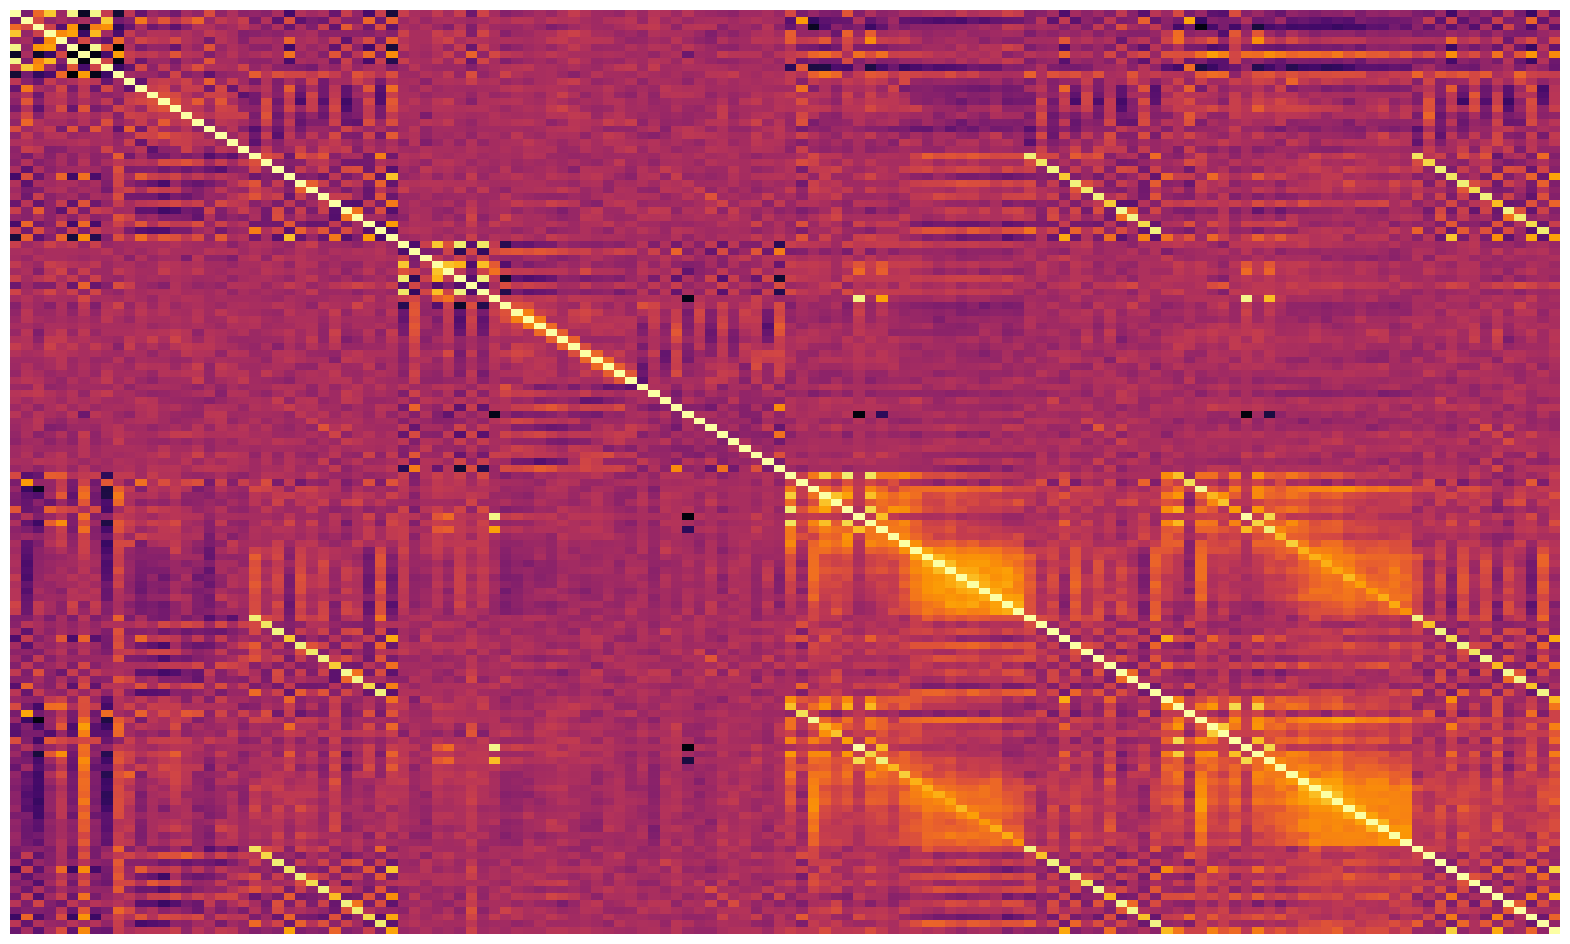

In [14]:
plt.figure(figsize=(20, 12))
sns.heatmap(dataframe.drop(['Band'],axis=1).corr(),
            annot=False, cbar=False, cmap='inferno', xticklabels=False, yticklabels=False)
plt.show()

### Visualy its hard to see the exact correlated features but there are some correlation according to the above heatmap. For that reason we features_corellation function. We use an absolute correlation threshold in which we delete the first of a pair of two features that have correlation > threshold.Threshold selected is 0.85.

In [15]:
new_dataframe , ff, pairs = features_corellation(dataframe,0.85)
print('Correlation of features with corellation > threshold \n')
print('From those features we delete automatically the first one using corellation_drop function \n')
pairs

Correlation of features with corellation > threshold 

From those features we delete automatically the first one using corellation_drop function 



[['spectral_entropy_mean', 'zcr_mean', 0.9389726131402164],
 ['spectral_rolloff_mean', 'zcr_mean', 0.9463923686642031],
 ['spectral_rolloff_mean', 'spectral_entropy_mean', 0.9598271288107815],
 ['delta spectral_entropy_mean', 'delta zcr_mean', 0.8986432089690048],
 ['delta spectral_rolloff_mean', 'delta zcr_mean', 0.8835570460378407],
 ['delta spectral_rolloff_mean',
  'delta spectral_entropy_mean',
  0.9273167901456855],
 ['spectral_entropy_std', 'zcr_std', 0.906754574797214],
 ['spectral_flux_std', 'delta mfcc_1_mean', 0.9390045927452966],
 ['spectral_rolloff_std', 'zcr_std', 0.8656684056564434],
 ['chroma_1_std', 'chroma_1_mean', 0.9140003408453974],
 ['chroma_2_std', 'chroma_2_mean', 0.8764536631949398],
 ['chroma_3_std', 'chroma_3_mean', 0.9360612834384272],
 ['chroma_5_std', 'chroma_5_mean', 0.9223606955766215],
 ['chroma_6_std', 'chroma_6_mean', 0.8881919290421612],
 ['chroma_7_std', 'chroma_7_mean', 0.9270812282790093],
 ['chroma_9_std', 'chroma_9_mean', 0.9635050740615609],
 [

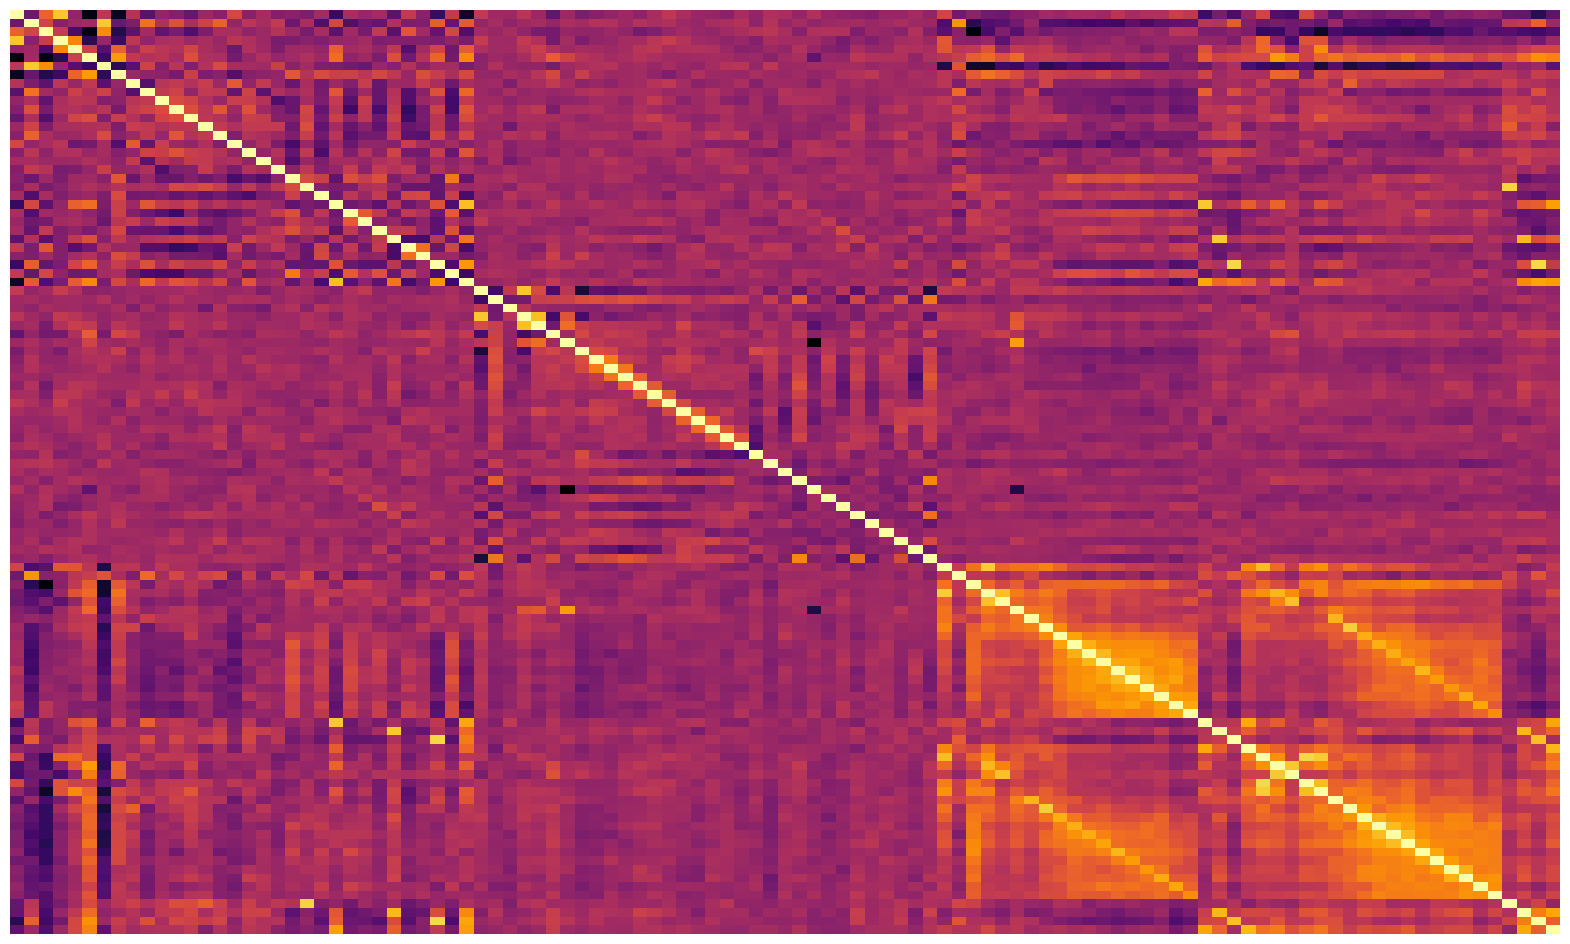

In [16]:
## New heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(new_dataframe.drop(['Band'],axis=1).corr(),
            annot=False, cbar=False, cmap='inferno', xticklabels=False, yticklabels=False)
plt.show()

In [17]:
new_dataframe.head()

,zcr_mean,Band,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_flux_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,delta spectral_flux_mean,delta mfcc_1_mean,delta mfcc_2_mean,delta mfcc_3_mean,delta mfcc_4_mean,delta mfcc_5_mean,delta mfcc_6_mean,delta mfcc_7_mean,delta mfcc_8_mean,delta mfcc_9_mean,delta mfcc_10_mean,delta mfcc_11_mean,delta mfcc_12_mean,delta mfcc_13_mean,delta chroma_1_mean,delta chroma_2_mean,delta chroma_3_mean,delta chroma_4_mean,delta chroma_5_mean,delta chroma_6_mean,delta chroma_7_mean,delta chroma_8_mean,delta chroma_9_mean,delta chroma_10_mean,delta chroma_11_mean,delta chroma_12_mean,delta chroma_std_mean,zcr_std,energy_std,energy_entropy_std,spectral_centroid_std,spectral_spread_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,mfcc_13_std,chroma_4_std,chroma_8_std,chroma_11_std,chroma_std_std,delta zcr_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_rolloff_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_2_std,delta chroma_8_std,delta chroma_11_std,delta chroma_std_std
0,0.105385,0,0.055962,2.973362,0.217836,0.238056,0.003121,-22.209769,1.913764,0.683987,0.311800,0.239603,0.302346,-0.008932,0.048539,0.132862,0.116120,-0.044705,-0.071674,-0.112864,0.020145,0.039492,0.009441,0.075376,0.007739,0.034257,0.005101,0.053727,0.003470,0.011554,0.041978,0.005464,0.031208,0.000066,-0.000189,0.001634,5.029656e-07,0.000006,0.000014,-0.002540,0.000769,-0.000572,-0.000297,-0.001637,-0.000614,0.000154,-0.000640,-0.000579,0.000878,0.001067,0.000021,-0.000731,-0.000059,-0.000143,0.000014,0.000438,3.503906e-07,0.000014,2.772177e-05,-0.000085,9.925657e-06,-0.000128,-0.000033,5.465672e-06,0.000042,0.055434,0.025014,0.210067,0.049773,0.022941,1.025402,0.277116,0.209971,0.225534,0.271548,0.202491,0.211478,0.209852,0.251798,0.218198,0.177857,0.152304,0.156574,0.051193,0.035526,0.026589,0.010611,0.030248,0.027084,0.014076,0.278913,0.079267,0.236999,0.190309,0.209212,0.219808,0.197455,0.194030,0.189635,0.198200,0.173034,0.174869,0.162388,0.149764,0.027838,0.035321,0.030127,0.010504
1,0.099801,0,0.051757,2.926394,0.219995,0.244148,0.003192,-22.290414,2.044807,0.738373,0.209863,0.245820,0.283070,0.056932,-0.008721,0.013003,0.179105,0.007752,-0.012975,-0.021616,0.010144,0.033484,0.010441,0.077619,0.008527,0.032951,0.005661,0.073763,0.003923,0.014287,0.050747,0.002633,0.033143,0.000219,-0.000020,-0.000684,3.281819e-04,0.000282,0.000003,0.000514,-0.000261,0.000760,0.000283,0.000287,-0.001097,-0.000483,0.000227,0.000277,0.000475,-0.000040,-0.000022,-0.000497,0.000032,0.000011,-0.000187,0.000123,-4.019196e-06,0.000104,1.586985e-05,-0.000148,-5.973186e-07,-0.000015,-0.000065,-5.046962e-06,-0.000014,0.035847,0.024760,0.221726,0.034216,0.016558,0.587949,0.275642,0.241553,0.179819,0.217594,0.189589,0.180444,0.165247,0.209510,0.179180,0.171155,0.172696,0.146012,0.045645,0.049252,0.025127,0.012136,0.021952,0.018789,0.009338,0.209661,0.063707,0.242011,0.232088,0.177156,0.197922,0.188475,0.181420,0.181819,0.190373,0.188070,0.177789,0.170486,0.147958,0.023070,0.052643,0.028635,0.011269
2,0.122400,0,0.040627,3.079595,0.231968,0.235578,0.002018,-22.058860,1.761161,0.545488,0.144387,0.088130,0.262398,0.009083,-0.077841,0.017002,0.242769,0.049761,-0.014374,0.040248,0.011987,0.0308

In [18]:
print(f"New data features are {len(new_dataframe.columns)-1}")
print(f"Number of features dropped = {len(dataframe.columns)-len(new_dataframe.columns)}")
## Save new dataset
new_dataframe.to_csv('../clean_data/corr_matrix_dataset',index=False)

New data features are 107
Number of features dropped = 29


## Step 7: Model fitting and hyperparameter tuning
### The dataset is comprised of 250 instances with 50 instances per label. Because the amount of data is low, there wasn't a dataset split of train-test. A repeated shuffle split for cross validation was conducted on the whole dataset. The train-validation ratio was 200-50. In each different split, a total of 40 riffs were used for training and 10 for testing  per band randomly. Standard scaling was performed based on train data and scaling happened on both train and test data.This happened 20 times and then the best model was selected based on the average macro f1 score over those 20 folds. Also the standard deviation and other metrics were computed. 

### 3 classifiers are used: Logistic Regression, KNN, SVM

In [19]:
def best_metrics(params,train,test):
    print("Best model parameters")
    print(params)
    print()
    print("================Train================")
    print(f"Training F1 = {np.array(train[0]).mean():.3f} +- {np.array(train[0]).std():.3f}")
    print()
    print("================Test================")
    print(f"Test F1 = {np.array(test[0]).mean():.3f} +- {np.array(test[0]).std():.3f}")

## Logistic Regression

In [20]:
best_f1_lr = 0
l_scores = ['l2', 'none']
C_range = [0.01,0.1,1,10,100]

for c in C_range:
    for l in l_scores:
        model = LogisticRegression(C=c,penalty=l,max_iter=1000,random_state=42)
        train, test = cross_validate(model,new_dataframe)  
        if np.array(test[0]).mean() > best_f1_lr:
            best_f1_lr = np.array(test[0]).mean()
            best_lr = model.get_params()
            train_lr = train
            test_lr = test

In [21]:
print('Best Logistic regression results')
best_metrics(best_lr,train_lr,test_lr)

Best Logistic regression results
Best model parameters
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

================Train================
Training F1 = 0.890 +- 0.014

================Test================
Test F1 = 0.708 +- 0.060


## K Neighbors Classifier

In [22]:
best_f1 = 0
p_range = [1,2]
k_range = range(2,15)
for p in p_range:
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k,p=p)
        train, test = cross_validate(model,new_dataframe)        
        if np.array(test[0]).mean() > best_f1:
            best_f1 = np.array(test[0]).mean()
            best_knn = model.get_params()
            train_knn = train
            test_knn = test

In [23]:
print('Best KNN results')
best_metrics(best_knn,train_knn,test_knn)

Best KNN results
Best model parameters
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}

================Train================
Training F1 = 0.780 +- 0.018

================Test================
Test F1 = 0.684 +- 0.053


## Support Vector Machines

In [24]:
best_f1 = 0
kernel = ['rbf','linear','sigmoid']
C = [0.001,0.005,0.01,0.1,1,10]
for k in kernel:
    for c in C:
        model = SVC(kernel=k,C=c,probability=True)
        train, test = cross_validate(model,new_dataframe)
        if np.array(test[0]).mean() > best_f1 and np.array(train[0]).mean()< 0.95:
            best_f1 = np.array(test[0]).mean()
            best_svm = model.get_params()
            train_svm = train
            test_svm = test

In [25]:
print('Best SVM results')
best_metrics(best_svm,train_svm,test_svm)

Best SVM results
Best model parameters
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

================Train================
Training F1 = 0.840 +- 0.019

================Test================
Test F1 = 0.711 +- 0.069


## Step 8: Plotting results 

In [26]:
set(labels)

{'Dream_Theater', 'Gojira', 'Mastodon', 'Opeth', 'Symphony X'}

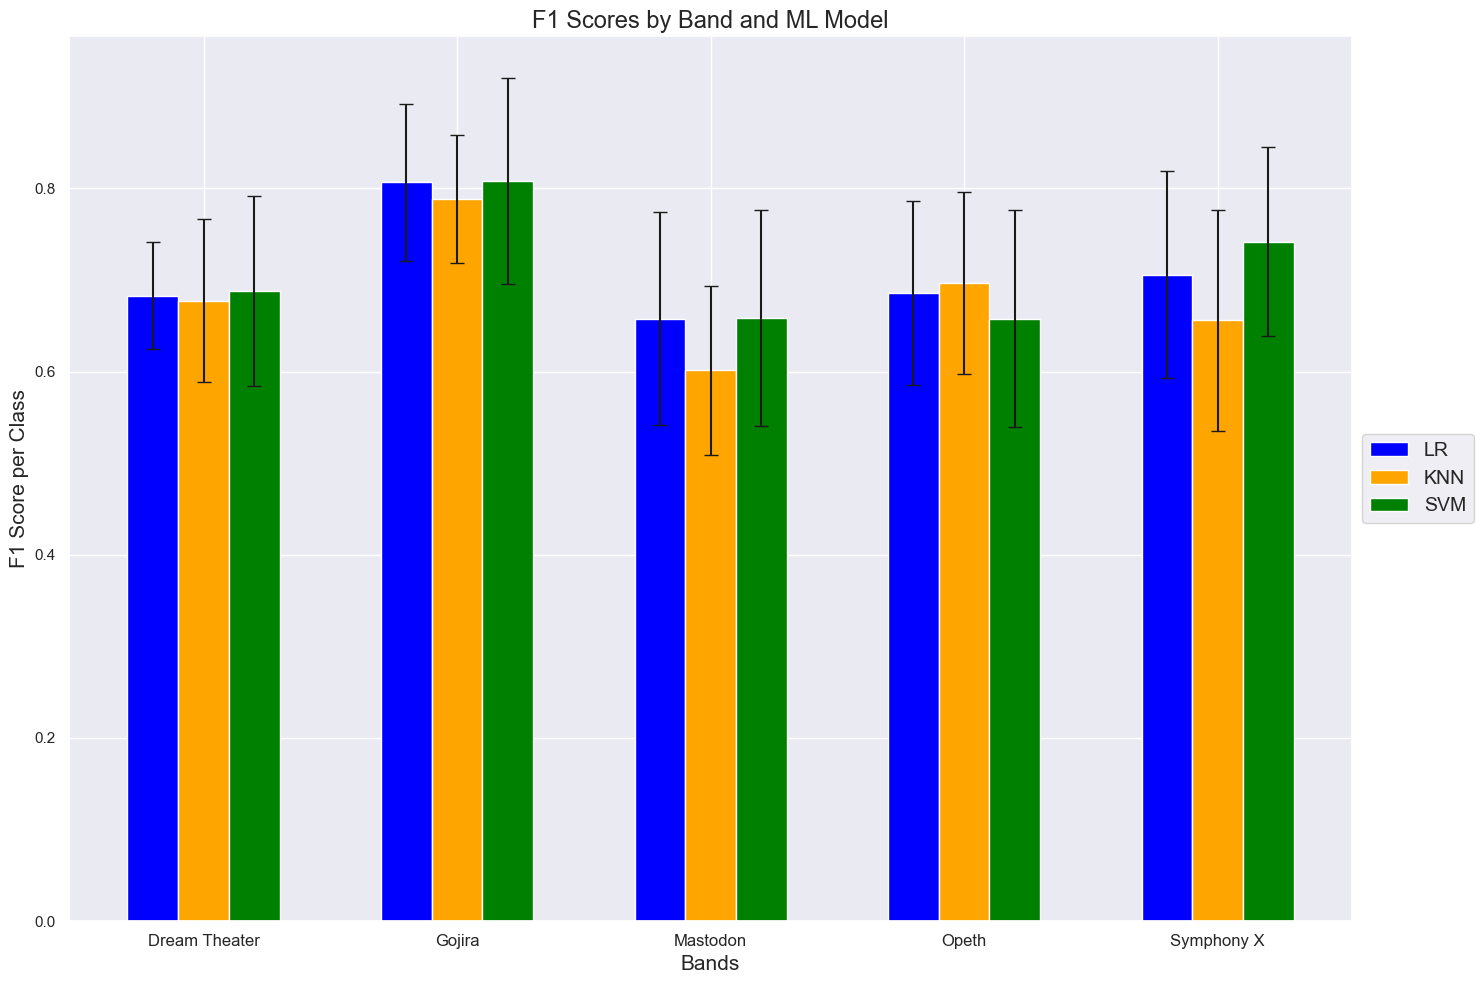

In [27]:
bands = ['Dream Theater', 'Gojira', 'Mastodon', 'Opeth', 'Symphony X']
all_lr_f1_mean = [mean for mean in test_lr[1]['f1_score'][0]]
all_knn_f1_mean = [mean for mean in test_knn[1]['f1_score'][0]]
all_svm_f1_mean = [mean for mean in test_svm[1]['f1_score'][0]]

all_lr_f1_std = [std for std in test_lr[1]['f1_score'][1]]
all_knn_f1_std = [std for std in test_knn[1]['f1_score'][1]]
all_svm_f1_std = [std for std in test_svm[1]['f1_score'][1]]

sns.set_theme()
n_groups = len(bands)
bar_width = 0.2

# Calculate the positions of the groups and indexes
ix = np.arange(n_groups)
group1_pos = ix - bar_width
group2_pos = ix
group3_pos = ix + bar_width

fig, ax = plt.subplots(figsize=(15, 10)) 
bar1 = ax.bar(group1_pos, all_lr_f1_mean, bar_width, label='LR', yerr=all_lr_f1_std, capsize=5, color='blue')
bar2 = ax.bar(group2_pos, all_knn_f1_mean, bar_width, label='KNN', yerr=all_knn_f1_std, capsize=5, color='orange')
bar3 = ax.bar(group3_pos, all_svm_f1_mean, bar_width, label='SVM', yerr=all_svm_f1_std, capsize=5, color='green')

ax.set_xlabel('Bands', fontsize=15)
ax.set_ylabel('F1 Score per Class', fontsize=15)
ax.set_title('F1 Scores by Band and ML Model', fontsize = 17)
ax.set_xticks(ix)
ax.set_xticklabels(bands,fontsize=12)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.tight_layout()
plt.show()

## Plot analysis:

### Generally the results obtained with this approach are good. We can see that each band F1 score is above 0.6. It seems like band 2 = Gojira is better recognized as oppossed to the other 4 bands. With this method, there might be a data leakage concerning the test set. Some songs from a particular album can be both on the train and the validation set. To examine this potential bias we select a new approach.

## Step 9: Examine potential bias
### In cross validation, there are cases that songs from the same album appear both in train and in test set. The next step is to create a test set that contains albums that are not present in the training set. This test set is comprised of 14 instances per class.

## Repeat the same proccess but leave the test set hidden

In [28]:
wavs_train , labels_train = data_import('..\\raw_data_2\\Train')
wavs_test, labels_test = data_import('..\\raw_data_2\\Test')

y_train = trim_wav(wavs_train)
y_test = trim_wav(wavs_test)

df_train = pyaudio_featurize(y_train)
df_test = pyaudio_featurize(y_test)

merge_labels(df_train,labels_train)
merge_labels(df_test,labels_test)

df_train , ff, pairs = features_corellation(df_train,0.85)
df_test = df_test.drop(ff,axis=1)

X_train = df_train.drop(['Band'], axis=1)
y_train = df_train['Band']

X_test = df_test.drop(['Band'], axis=1)
y_test = df_test['Band']

### Perform the same Grid Search CV as before for hyperparameter tuning on the train dataset.

In [49]:
best_f1_lr = 0
l_scores = ['l2', 'none']
C_range = [0.01,0.1,1,10,100]
df_train = df_train.sample(frac=1).reset_index(drop=True)
for c in C_range:
    for l in l_scores:
        model = LogisticRegression(C=c,penalty=l,max_iter=1000,random_state=42)
        train, test = cross_validate(model,df_train)  
        if np.array(test[0]).mean() > best_f1_lr and np.array(train[0]).mean()< 1:
            best_f1_lr = np.array(test[0]).mean()
            best_lr = model.get_params()
            train_lr = train
            test_lr = test
            
print('Best Logistic regression results')
best_metrics(best_lr,train_lr,test_lr)
print()
            
best_f1_knn = 0
p_range = [1,2]
k_range = range(2,15)
for p in p_range:
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k,p=p)
        train, test = cross_validate(model,df_train)        
        if np.array(test[0]).mean() > best_f1_knn and np.array(train[0]).mean()< 1:
            best_f1_knn = np.array(test[0]).mean()
            best_knn = model.get_params()
            train_knn = train
            test_knn = test

print('Best KNN results')
best_metrics(best_knn,train_knn,test_knn)
print()

best_f1_svm = 0
kernel = ['rbf','linear','sigmoid','poly']
C = [0.001,0.005,0.01,0.1,0.5,1,10]
for k in kernel:
    for c in C:
        model = SVC(kernel='linear',C=c,probability=True)
        train, test = cross_validate(model,df_train)
        if np.array(test[0]).mean() > best_f1_svm and np.array(train[0]).mean()< 1:
            best_f1_svm = np.array(test[0]).mean()
            best_svm = model.get_params()
            train_svm = train
            test_svm = test
                
print('Best SVM results')
best_metrics(best_svm,train_svm,test_svm)

Best Logistic regression results
Best model parameters
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

================Train================
Training F1 = 0.947 +- 0.016

================Test================
Test F1 = 0.770 +- 0.062

Best KNN results
Best model parameters
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

================Train================
Training F1 = 0.836 +- 0.020

================Test================
Test F1 = 0.721 +- 0.051

Best SVM results
Best model parameters
{'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max

### Step 10: Plot confusion matrix on the best Models from each of the 3 methods
### First is LR
### Second is KNN
### Third is SVM

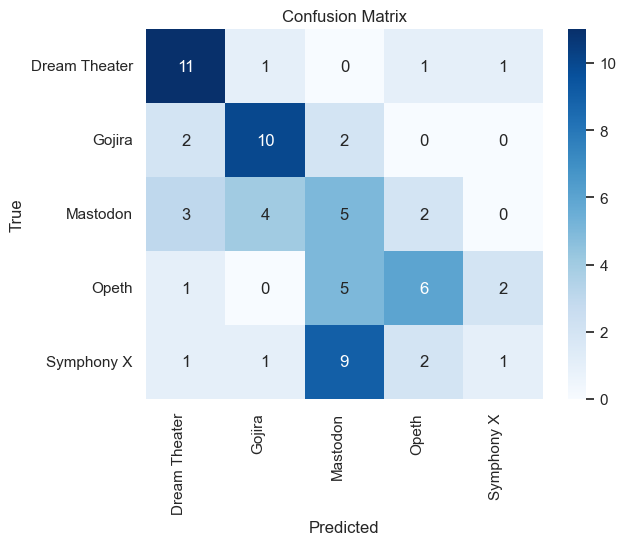

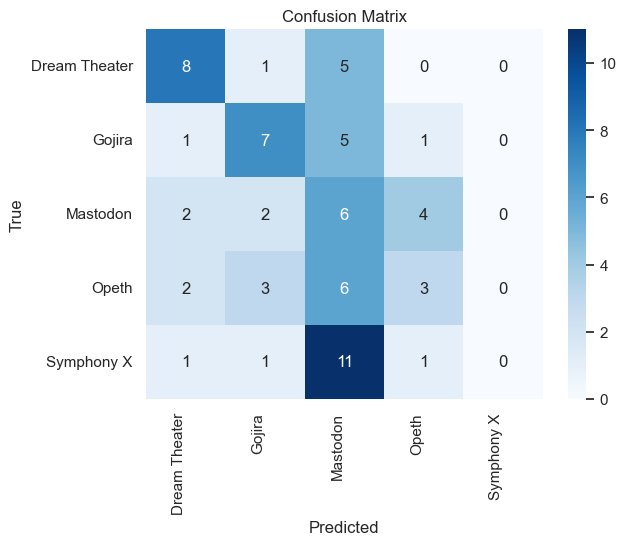

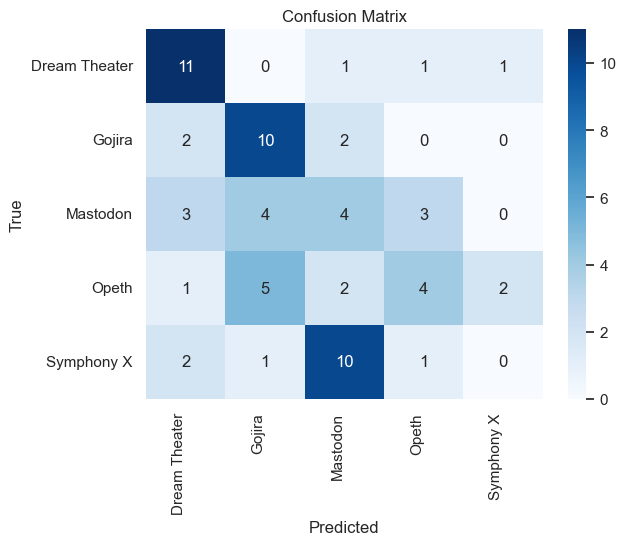

In [29]:
X_train = df_train.drop(['Band'], axis=1)
y_train = df_train['Band']

X_test = df_test.drop(['Band'], axis=1)
y_test = df_test['Band']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression(C=0.01,penalty='l2',max_iter=1000,random_state=42)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)

knn = KNeighborsClassifier(n_neighbors=5,p=1)
knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)

svm = SVC(C=0.01, kernel='linear',probability=True)
svm.fit(X_train,y_train)
svm_preds = svm.predict(X_test)

cm_lr = confusion_matrix(y_test,lr_preds)
cm_knn = confusion_matrix(y_test,knn_preds)
cm_svm = confusion_matrix(y_test,svm_preds)

confusion = [cm_lr,cm_knn,cm_svm]

for ix,cm in enumerate(confusion): 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=bands, yticklabels=bands)

    # Add labels and title as needed
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)  # Set y-ticks to be horizontal
    
    plt.show()

## Confusion Matrix analysis
### We can crearly see that the results are not as good as the 1st approach. That implies album dependance of the songs. The first two bands can be recognised very easily. The 3rd and 4th band moderately-bad and in the 5th band there is total failure. Also the 5th band is missclassified as the 3rd band. Regarding the domain, this can be explained as influence that a band has on another and thus they are confused pretty easily.